<h1>Graph Anomaly Detection on Credit Card Transactions</h1>

### By: Huan Shuo Hsu

## Method Overview
This notebook applies Graph Analytics and the PageRank algorithm to identify anomalous Cardholder–Vendor relationships using a bipartite transaction network.  

We use:

- **NetworkX PageRank** to measure centrality and influence  
- **Degree vs PageRank log-log regression** to model expected structural behavior  
- **Residual analysis (z-scores)** to flag nodes whose PageRank deviates from structural expectation  
- **Trend analysis** across multiple months to identify persistent or sudden anomalies  


## Table of Contents
* [Section 1: Data Preparation](#1)
* [Section 2: Multi-Month Analysis](#2)
* [Section 3: Aggregating Anomalies Across Months](#3)
* [Section 4: Multi-Month Consistency Check](#4)
* [Section 5: Detecting Sudden PageRank Spikes or Drops](#5)
* [Section 6: Thoughts and Comparison to Previous Work](#6)


In [1]:
from __future__ import annotations
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm

from typing import Tuple

## Data Preperation <a name="1"></a>

This section loads all required libraries and sets configuration parameters for PageRank analysis.  
The key parameters include:

- `weight_by`: determines the edge weight (transaction count or dollar Amount)
- `alpha`: the damping factor for PageRank
- `min_degree_cardholders` & `min_degree_vendors`: flooring thresholds used during regression  
- `num_std_devs`: the z-score threshold used to flag anomalies

These parameters let us tune the graph model and anomaly sensitivity.


In [10]:
# configs

csv_path   = 'data/purchase_credit_card.csv'
weight_by  = "count"   # or "Amount" or another numeric column from the dataset
alpha      = 0.85
save_prefix = 'PageRanked'

min_degree_cardholders = 7
min_degree_vendors     = 7
num_std_devs           = 4  # anomaly cutoff on residual z-scores

### Data Loading and Feature Construction

This block loads the dataset (`purchase_credit_card.csv`), performs basic data quality checks, and constructs the `Cardholder` field by combining first initial and last name.  
We also extract the list of all `Year-Month` values, which will be used later for multi-month processing.

This step ensures a consistent identifier for each cardholder and prepares the data for graph construction.


In [3]:
# Data Loading and Preparation
df = pd.read_csv(csv_path, low_memory=False)

# Required columns
req = ["Year-Month", "Cardholder First Initial", "Cardholder Last Name", "Vendor"]
miss = [c for c in req if c not in df.columns]
if miss:
    raise ValueError(f"Missing required columns: {miss}")

# Build cardholder name
df = df.dropna(subset=["Cardholder First Initial", "Cardholder Last Name", "Vendor"]).copy()
df["Cardholder"] = (
    df["Cardholder First Initial"].astype(str).str.strip()
    + " "
    + df["Cardholder Last Name"].astype(str).str.strip()
)

# Identify all months in dataset
months = sorted(df["Year-Month"].dropna().unique().tolist())
months


df.head(10)


,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC),Cardholder
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,C Mason
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON,C Mason
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,J Massey
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS",T Massey
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",M Mauro-Herrera
5,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM...",M Mauro-Herrera
6,201307,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,19.87,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS",B Mays
7,201307,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,10.10,DAYLIGHT DONUTS,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,FAST FOOD RESTAURANTS,B Mays
8,201307,1000,OKLAHOMA STATE UNIVERSITY,McCarthy,D,GENERAL PURCHASE,142.60,UFIRST LAUNDRY SVCS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"MENS, WOMENS AND CHILDRENS UNIFORMS AND COMMER...",D McCarthy
9,201307,1000,OKLAHOMA STATE UNIVERSITY,McClurg,L,AT&T SERVICE PAYMENT ITM,29.99,AT&T DATA,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,TELECOMMUNICATION SERVICES,L McClurg


### Why Convert to a Bipartite Graph?

Each transaction connects a **Cardholder** to a **Vendor**.  
To apply PageRank, we model the data as a **bipartite directed graph**:

- Cardholders → Vendors  
- Vendors → Cardholders  

We add edges in *both* directions because standard PageRank requires a strongly connected directed graph to converge.  
Edge weights represent either the number of transactions or the total dollar amount.

This converts transactional data into a graph suitable for structural anomaly detection.


### Helper Functions: Regression + Anomaly Identification

`fit_loglog_pr_vs_degree()`

PageRank is expected to correlate with Degree (number of unique neighbors).  
However, this relationship is **non-linear** and **right-skewed**, so we:

1. Convert both variables to log-scale  
2. Fit a linear regression in log-space  
3. Compute residuals (observed – predicted log PageRank)

Nodes whose PageRank is far above or below what their Degree predicts are structurally unusual and potential anomalies.

`flag_residual_anomalies()`

This function converts residuals into z-scores and flags nodes that exceed the chosen standard-deviation threshold.

This provides a statistically principled way to identify PageRank outliers.


In [4]:
def fit_loglog_pr_vs_degree(
    df,
    rank_col="rank",
    degree_col="degree",
    min_degree=1,
    title_prefix=None
):
    # Filter
    point_df = df.loc[df[degree_col] >= min_degree, [rank_col, degree_col]].copy()
    if point_df.empty:
        raise ValueError(f"No rows with degree >= {min_degree}")

    # Logs
    EPS = 1e-12
    point_df["log_degree"] = np.log(point_df[degree_col].astype(float))
    point_df["log_rank"]   = np.log(point_df[rank_col].astype(float) + EPS)

    # Fit OLS
    X = sm.add_constant(point_df["log_degree"].to_numpy())
    y = point_df["log_rank"].to_numpy()
    model = sm.OLS(y, X).fit()

    # Predictions & residuals
    point_df["yhat_log"] = model.predict(X)
    point_df["resid_log"] = point_df["log_rank"] - point_df["yhat_log"]

    # Plot
    x_grid = np.linspace(point_df["log_degree"].min(), point_df["log_degree"].max(), 200)
    Xg = sm.add_constant(x_grid)
    yhat_grid = model.predict(Xg)

    plt.figure(figsize=(6, 4))
    plt.scatter(point_df["log_degree"], point_df["log_rank"], s=12, alpha=0.7)
    plt.plot(x_grid, yhat_grid, color="red", lw=2)
    plt.xlabel("log(degree)")
    plt.ylabel("log(PageRank)")
    plt.title(f"{title_prefix} log(PageRank) vs log(degree)")

    plt.tight_layout()
    plt.show()

    return model, point_df, pd.DataFrame({"x_log": x_grid, "yhat_log": yhat_grid})


def flag_residual_anomalies(df, resid_col="resid_log", threshold=4):
    mu = df[resid_col].mean(skipna=True)
    sigma = df[resid_col].std(skipna=True)
    df["resid_zscore"] = (df[resid_col] - mu) / sigma
    df["is_anomaly"] = df["resid_zscore"].abs() > threshold
    return df


## Multi-Month Analysis <a name="2"></a>


### Single-Month Graph Processing Function

`run_one_month()` encapsulates the entire PageRank anomaly detection pipeline for a single month.  
This is required because PageRank cannot be run on the entire year at once due to convergence and scalability constraints.

For each month, this function:

1. **Constructs a bipartite directed graph**
2. **Computes weighted PageRank**
3. **Assembles user/vendor tables with degree and PageRank**
4. **Fits the log-log PageRank–Degree model**
5. **Computes residuals and z-scores**
6. **Flags anomalies**
7. **Saves monthly results**

This modular structure allows us to loop through all months in the dataset.


In [5]:
def run_one_month(month_val) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    month_df = df[df["Year-Month"] == month_val].copy()
    if month_df.empty:
        raise ValueError(f"No data for month {month_val}")

    # Edge Table
    if weight_by == "count":
        edges = (
            month_df.groupby(["Cardholder", "Vendor"], as_index=False)
                    .size()
                    .rename(columns={"size": "weight"})
        )
    else:
        edges = (
            month_df.groupby(["Cardholder", "Vendor"], as_index=False)[weight_by]
                    .sum()
                    .rename(columns={weight_by: "weight"})
        )
    edges["weight"] = edges["weight"].astype(float)

    # Graph Construction
    G = nx.DiGraph()
    users = edges["Cardholder"].unique()
    vendors = edges["Vendor"].unique()
    G.add_nodes_from(users, bipartite=0)
    G.add_nodes_from(vendors, bipartite=1)

    triples = list(map(tuple, edges[["Cardholder", "Vendor", "weight"]].to_numpy()))
    G.add_weighted_edges_from(triples)
    G.add_weighted_edges_from([(v, u, w) for u, v, w in triples])

    # PageRank Calculation
    try:
        pr = nx.pagerank(G, alpha=alpha, weight="weight", max_iter=200, tol=1e-10)
    except nx.PowerIterationFailedConvergence:
        print(f"[WARN] PageRank failed to converge for {month_val}")
        return (None, None, None, None)

    degree = dict(G.degree(weight=None))

    # Assemble DataFrames
    users_df = pd.DataFrame({
        "Cardholder": users,
        "rank": [pr.get(u, 0) for u in users],
        "degree": [degree.get(u, 0) for u in users],
        "Year-Month": month_val,
    })

    vendors_df = pd.DataFrame({
        "Vendor": vendors,
        "rank": [pr.get(v, 0) for v in vendors],
        "degree": [degree.get(v, 0) for v in vendors],
        "Year-Month": month_val,
    })

    # Regression & Residuals
    model_u, pts_u, _ = fit_loglog_pr_vs_degree(
        users_df, min_degree=min_degree_cardholders,
        title_prefix=f"Cardholders [{month_val}]"
    )
    model_v, pts_v, _ = fit_loglog_pr_vs_degree(
        vendors_df, min_degree=min_degree_vendors,
        title_prefix=f"Vendors [{month_val}]"
    )

    for df_side, pts in [(users_df, pts_u), (vendors_df, pts_v)]:
        cols = ["log_degree", "log_rank", "yhat_log", "resid_log"]
        df_side.drop(columns=[c for c in cols if c in df_side], errors="ignore", inplace=True)
        df_side[cols] = pts[cols].reindex(df_side.index)

    # Anomaly Flagging
    users_df = flag_residual_anomalies(users_df, threshold=num_std_devs)
    vendors_df = flag_residual_anomalies(vendors_df, threshold=num_std_devs)

    user_anoms = users_df[users_df["is_anomaly"]]
    vendor_anoms = vendors_df[vendors_df["is_anomaly"]]

    # Saving Results
    users_df.to_csv(f"data/{save_prefix}_cardholders_{month_val}.csv", index=False)
    vendors_df.to_csv(f"data/{save_prefix}_vendors_{month_val}.csv", index=False)

    print(f"[{month_val}] User anomalies: {len(user_anoms)}, Vendor anomalies: {len(vendor_anoms)}")

    return users_df, vendors_df, user_anoms, vendor_anoms


This section iterates over every unique month in the dataset and applies the monthly PageRank pipeline.  
We store all cardholder and vendor anomalies across months so that they can be analyzed later.


=== Running Month 201307 ===


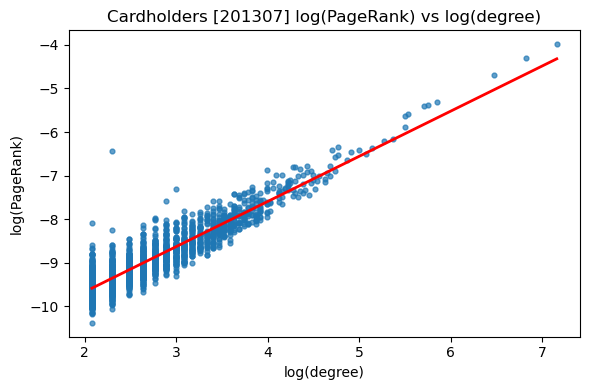

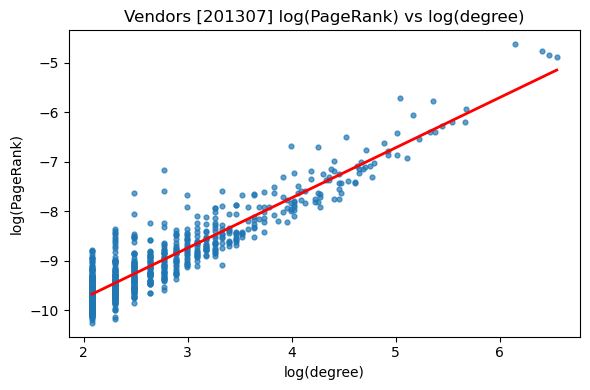

[201307] User anomalies: 3, Vendor anomalies: 3

=== Running Month 201308 ===


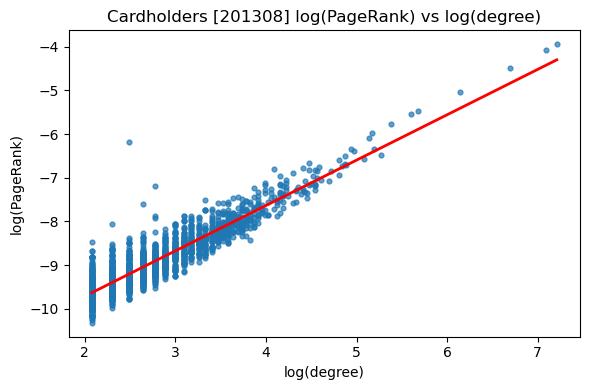

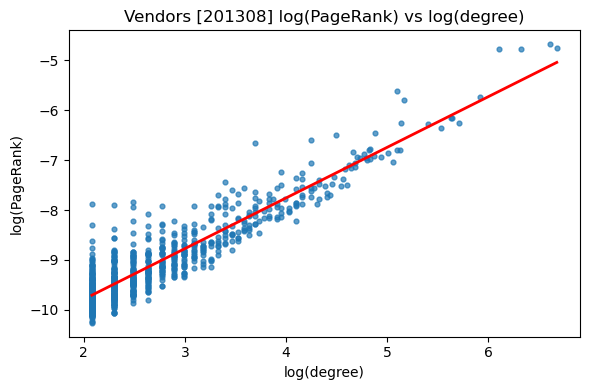

[201308] User anomalies: 4, Vendor anomalies: 5

=== Running Month 201309 ===


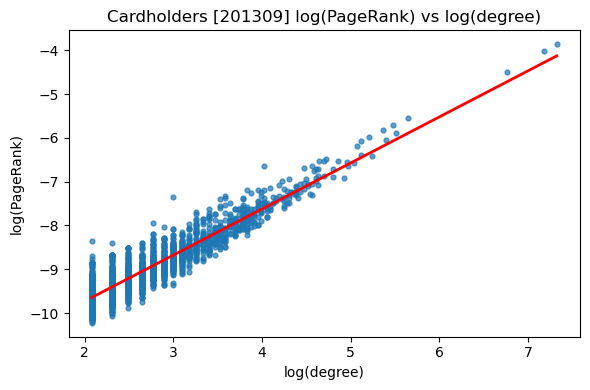

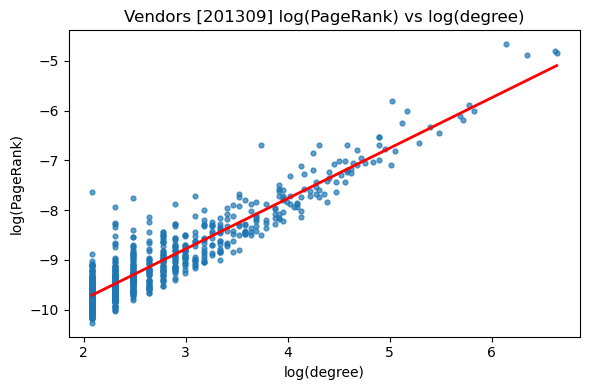

[201309] User anomalies: 2, Vendor anomalies: 4

=== Running Month 201310 ===


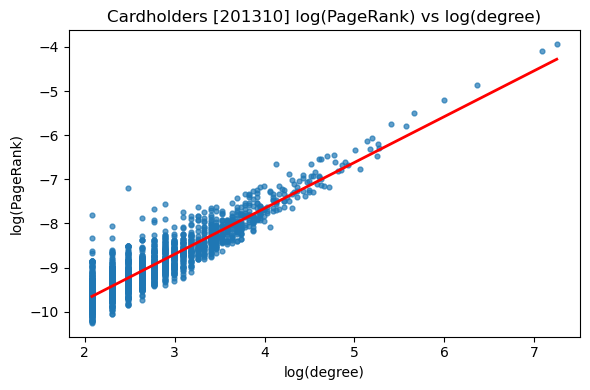

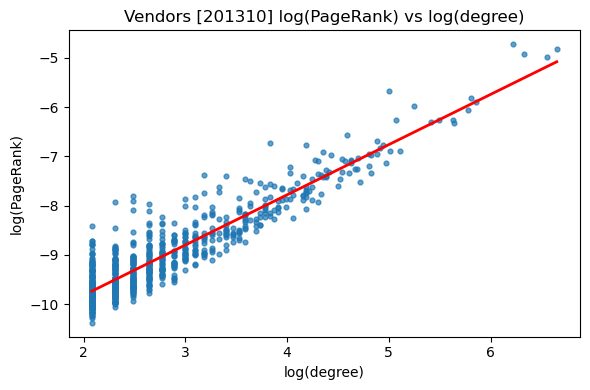

[201310] User anomalies: 7, Vendor anomalies: 3

=== Running Month 201311 ===


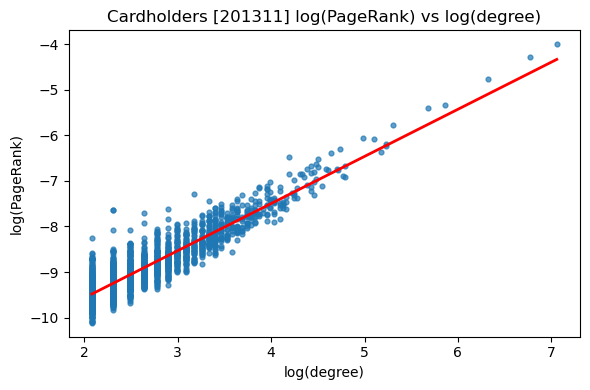

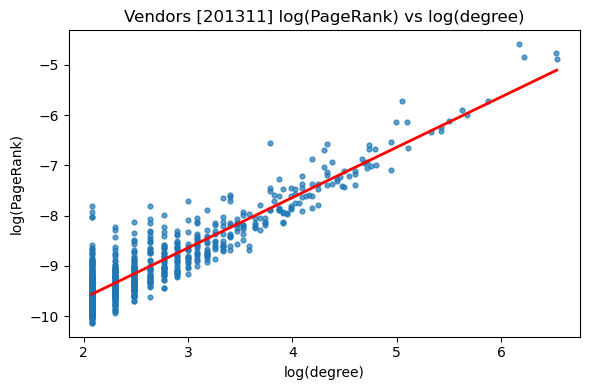

[201311] User anomalies: 5, Vendor anomalies: 4

=== Running Month 201312 ===


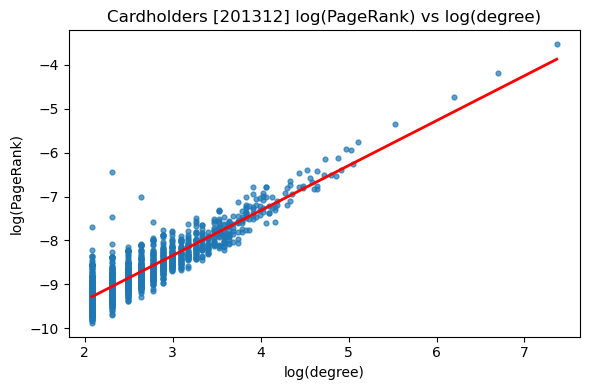

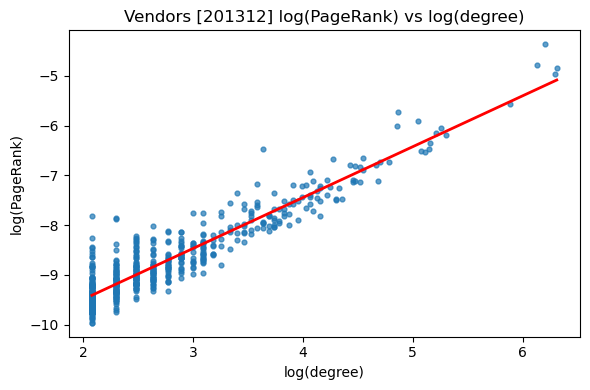

[201312] User anomalies: 4, Vendor anomalies: 4

=== Running Month 201401 ===


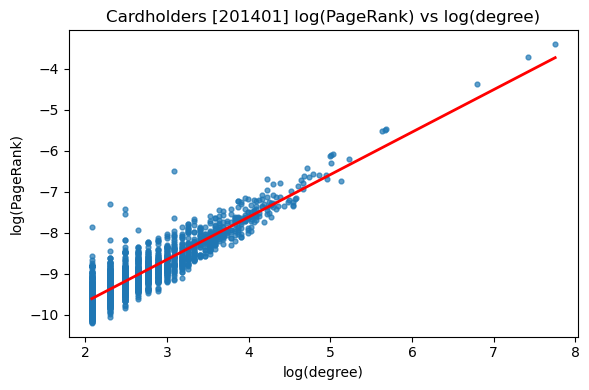

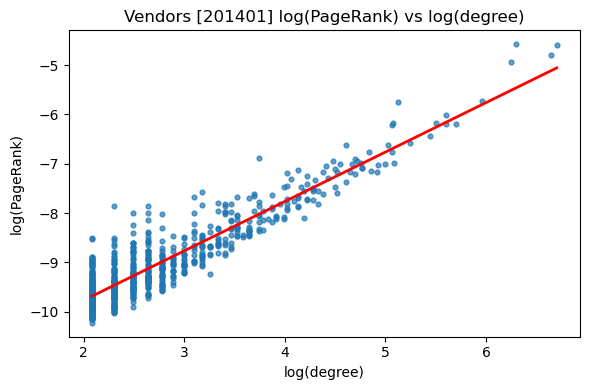

[201401] User anomalies: 5, Vendor anomalies: 1

=== Running Month 201402 ===


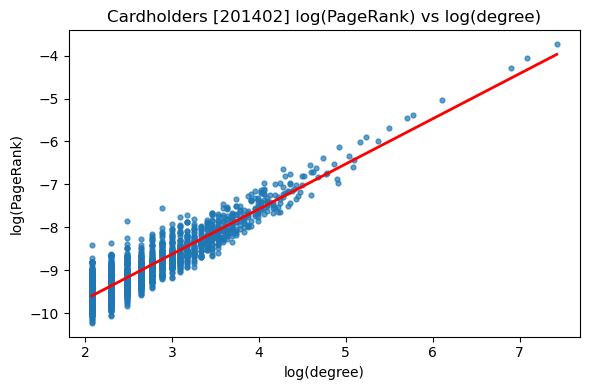

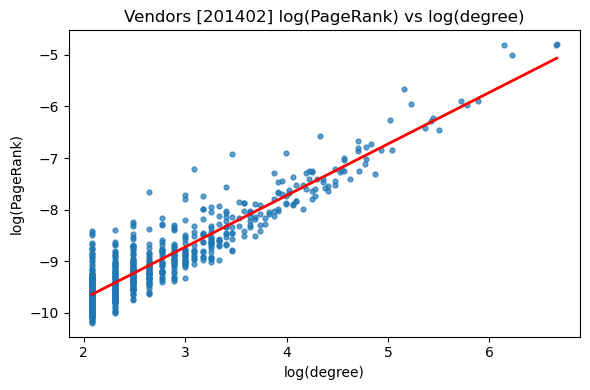

[201402] User anomalies: 3, Vendor anomalies: 3

=== Running Month 201403 ===


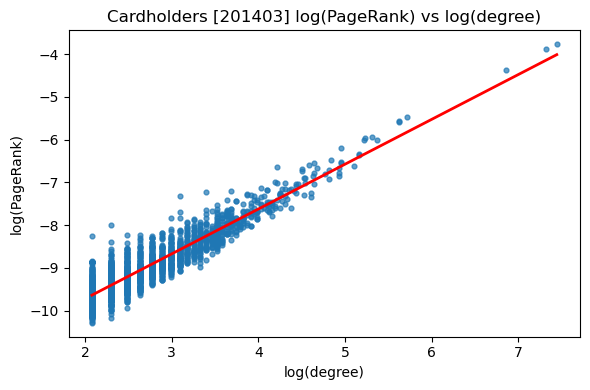

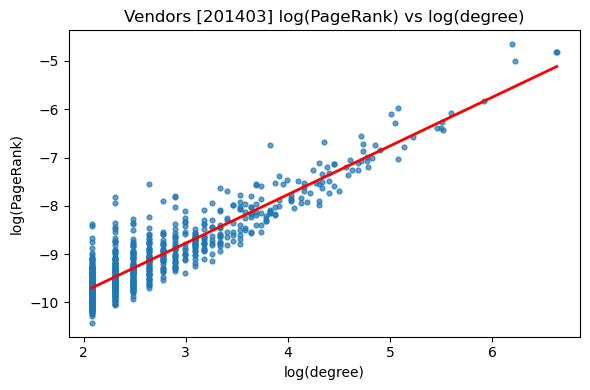

[201403] User anomalies: 3, Vendor anomalies: 3

=== Running Month 201404 ===


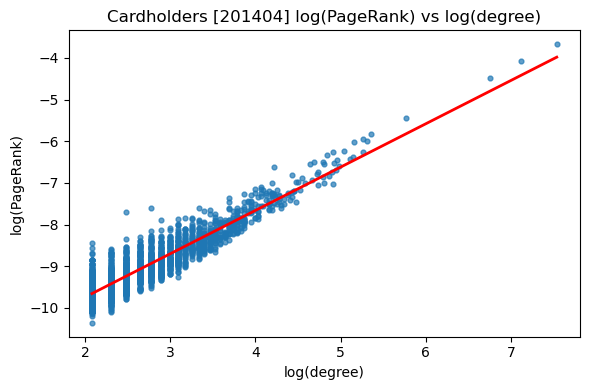

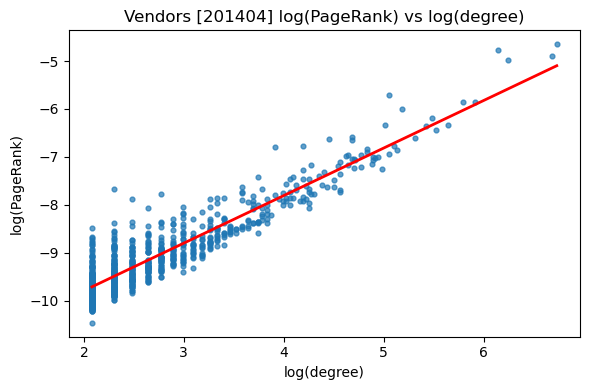

[201404] User anomalies: 3, Vendor anomalies: 2

=== Running Month 201405 ===


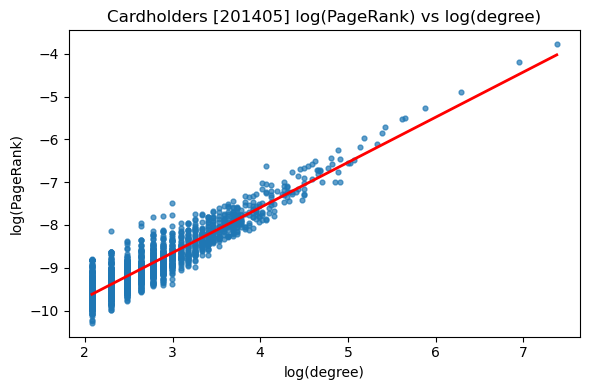

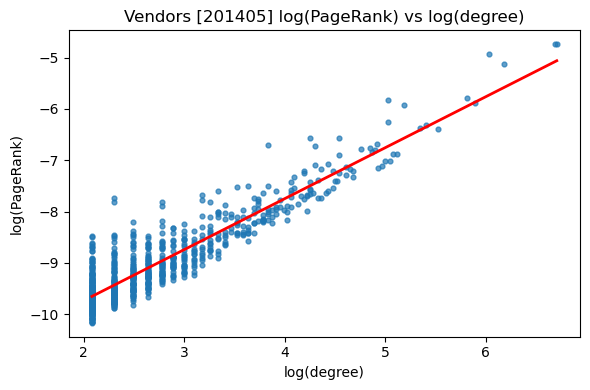

[201405] User anomalies: 2, Vendor anomalies: 2

=== Running Month 201406 ===


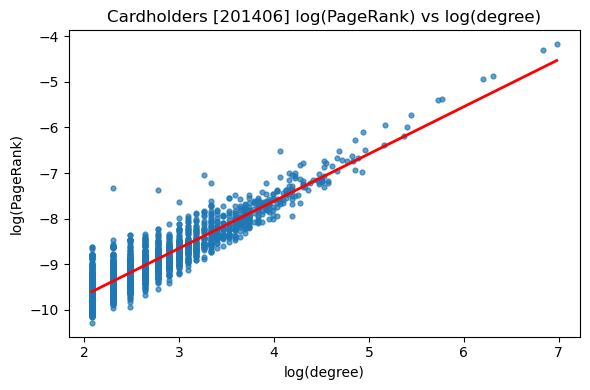

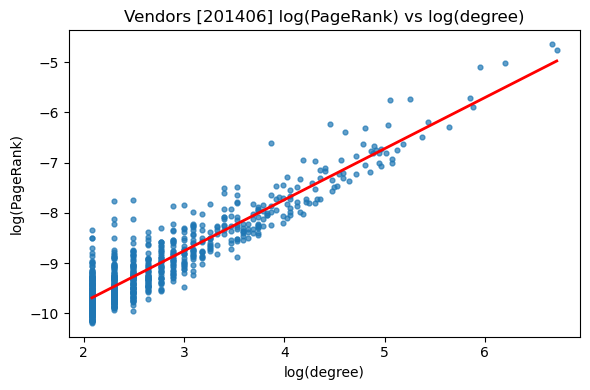

[201406] User anomalies: 3, Vendor anomalies: 2


In [6]:
all_user_anoms = []
all_vendor_anoms = []

for m in months:
    print(f"\n=== Running Month {m} ===")
    u_df, v_df, u_an, v_an = run_one_month(m)

    if u_an is not None and not u_an.empty:
        all_user_anoms.append(u_an)

    if v_an is not None and not v_an.empty:
        all_vendor_anoms.append(v_an)


# Aggregating Anomalies Across Months <a name="3"></a>

After processing all months, this block concatenates all per-month anomalies into:

- `PageRanked_anomalies_cardholders_ALL_MONTHS.csv`
- `PageRanked_anomalies_vendors_ALL_MONTHS.csv`

We display the top anomalies for the full year.  
These aggregated tables allow us to study long-term suspicious behavior and repeated anomalies.


In [7]:
if all_user_anoms:
    user_all = pd.concat(all_user_anoms, ignore_index=True)
    user_all.to_csv(f"data/{save_prefix}_anomalies_cardholders_ALL_MONTHS.csv", index=False)
    print("\nTop cardholder anomalies across all months:")
    display(user_all.head(15))
else:
    print("No cardholder anomalies found across all months.")

if all_vendor_anoms:
    vendor_all = pd.concat(all_vendor_anoms, ignore_index=True)
    vendor_all.to_csv(f"data/{save_prefix}_anomalies_vendors_ALL_MONTHS.csv", index=False)
    print("\nTop vendor anomalies across all months:")
    display(vendor_all.head(15))
else:
    print("No vendor anomalies found across all months.")



Top cardholder anomalies across all months:


,Cardholder,rank,degree,Year-Month,log_degree,log_rank,yhat_log,resid_log,resid_zscore,is_anomaly
0,A Batenhorst,0.001621,10,201307,2.302585,-6.424739,-9.355527,2.930788,10.055280,True
1,C Lemmings,0.000306,8,201307,2.079442,-8.092677,-9.586957,1.494281,5.126748,True
2,L SAUSINS,0.000673,20,201307,2.995732,-7.303590,-8.636638,1.333048,4.573572,True
3,A Batenhorst,0.002082,12,201308,2.484907,-6.174260,-9.208227,3.033966,10.353334,True
4,L SAUSINS,0.000755,16,201308,2.772589,-7.188552,-8.909269,1.720716,5.871902,True
5,N NICAR,0.000496,14,201308,2.639057,-7.608201,-9.048034,1.439834,4.913396,True
6,T Freeman,0.000316,10,201308,2.302585,-8.059446,-9.397695,1.338249,4.566741,True
7,J BRADEN,0.000233,8,201309,2.079442,-8.363595,-9.643777,1.280182,4.542838,True
8,L SAUSINS,0.000645,20,201309,2.995732,-7.345491,-8.680378,1.334887,4.736963,True
9,C Bowlin,0.000317,10,201310,2.302585,-8.055643,-9.421506,1.365864,4.625763,True



Top vendor anomalies across all months:


,Vendor,rank,degree,Year-Month,log_degree,log_rank,yhat_log,resid_log,resid_zscore,is_anomaly
0,NPDB NPDB-HIPDB.HRSA.GOV,0.000503,16,201307,2.772589,-7.594306,-8.972406,1.378100,4.109938,True
1,REXEL2442,0.000487,12,201307,2.484907,-7.627396,-9.263603,1.636207,4.879694,True
2,Amazon Services-Kindle,0.000779,16,201307,2.772589,-7.157997,-8.972406,1.814408,5.411149,True
3,HARD ROCK HOTEL TULSA,0.000382,8,201308,2.079442,-7.869070,-9.706100,1.837030,5.383489,True
4,MCKESSON MEDICAL SUPPLY,0.001276,40,201308,3.688879,-6.663892,-8.074083,1.410191,4.132621,True
5,NPDB NPDB-HIPDB.HRSA.GOV,0.000369,10,201308,2.302585,-7.905965,-9.479826,1.573861,4.612262,True
6,REXEL2442,0.000391,12,201308,2.484907,-7.845602,-9.294947,1.449345,4.247362,True
7,PSS 2025,0.000247,8,201308,2.079442,-8.307558,-9.706100,1.398542,4.098484,True
8,MCKESSON MEDICAL SUPPLY,0.001231,42,201309,3.737670,-6.699580,-8.033584,1.334005,4.063348,True
9,NPDB NPDB-HIPDB.HRSA.GOV,0.000359,10,201309,2.302585,-7.932679,-9.486426,1.553747,4.732678,True


These are the top ranked anomalies across all months:


**Cardholder Insights**

Most notably `L. Sausins` and `A. Batenhorst` repeatedly appear as anomalies over multiple months. Their PageRank scores are significantly higher than predicted given their number of vendor connections, indicating unusually influential or structurally irregular purchasing patterns.


**Vendor Insights**

`NPDB NPDB-HIPDB.HRSA.GOV`, `REXEL2442`, and `MCKESSON MEDICAL SUPPLY` stand out as persistent anomalies. These vendors consistently receive more influence than their degree would typically justify, suggesting they act as disproportionately central hubs in the network.

## Multi-Month Consistency Check <a name="4"></a>

This block examines whether the **same node is flagged in multiple months**.  
Repeated anomalies are a strong sign of consistent suspicious behavior, potentially indicating:

- Fraudulent cardholders/vendors  
- Ghost vendors  
- Coordinated activity  
- Structurally unusual transaction patterns  


In [8]:
# Cardholders flagged across multiple months
if all_user_anoms:
    # Group by actual cardholder column
    user_repeats = (
        user_all.groupby("Cardholder")["Year-Month"]
                .nunique()
                .sort_values(ascending=False)
    )
    print("Cardholders flagged across multiple months:")
    display(user_repeats.head(20))
else:
    print("No cardholder anomalies were found across all months.")

# Vendors flagged across multiple months
if all_vendor_anoms:
    vendor_repeats = (
        vendor_all.groupby("Vendor")["Year-Month"]
                  .nunique()
                  .sort_values(ascending=False)
    )
    print("Vendors flagged across multiple months:")
    display(vendor_repeats.head(20))
else:
    print("No vendor anomalies were found across all months.")


Cardholders flagged across multiple months:


Cardholder
L SAUSINS         12
A Batenhorst       5
M Caruthers        4
C Lemmings         3
L Devine           3
N NICAR            2
D CHAPPELL         2
S HAFFORD          2
T Freeman          1
S Kennedy          1
S CZENTNAR         1
R Varghese         1
B Smith-Morton     1
M Romero           1
C Bowlin           1
B Bradley          1
J LAMBERT          1
J BRADEN           1
T STUBBLEFIELD     1
Name: Year-Month, dtype: int64

Vendors flagged across multiple months:


Vendor
REXEL2442                   11
NPDB NPDB-HIPDB.HRSA.GOV     6
MCKESSON MEDICAL SUPPLY      4
NPDB NPDB.HRSA.GOV           3
PATTERSON DENTAL SUPPL       3
PSS 2025                     2
Amazon Services-Kindle       1
EMPIRE PAPER COMPANY         1
HAMPTON INN & SUITES         1
HARD ROCK HOTEL TULSA        1
OREILLY AUTO  00002501       1
RENAISSANCE HOTELS           1
WYNDHAM GARDEN HOTEL         1
Name: Year-Month, dtype: int64

The frequency tables show how often each cardholder and vendor was flagged as an anomaly across all months. This helps us distinguish one-off irregularities from persistent structural anomalies, which are far more meaningful.

**Cardholder Insights**

`L. Sausins` (12 months) is the strongest recurring anomaly—appearing almost every month. This indicates a long-term transaction pattern that consistently deviates from the normal PageRank–degree relationship, making this cardholder the most significant outlier in the dataset.

`A. Batenhorst`, `M. Caruthers`, `C. Lemmings`, and `L. Devine` appear 3–5 times, suggesting intermittently unusual spending patterns that repeat over time.

Several others appear only once or twice, which may represent isolated events rather than systemic behavior.


**Vendor Insights**

`REXEL2442` (11 months) is by far the most consistently anomalous vendor, flagged almost every month. Its PageRank is repeatedly higher than expected given its degree, implying unusually central or influential positioning in the transaction network.

`NPDB NPDB-HIPDB.HRSA.GOV`, `MCKESSON MEDICAL SUPPLY`, and `PATTERSON DENTAL SUPPL` also appear multiple times, indicating recurring atypical vendor–cardholder interaction patterns.

Other vendors appear only once or twice, pointing to sporadic irregularities.

## Detecting Sudden PageRank Spikes or Drops <a name="5"></a>

This section reloads all the monthly PageRank CSV reports and computes:

- Month-to-month PageRank changes
- Z-score thresholding for sudden jumps or collapses

Significant PageRank shifts can indicate:

- Sudden bursts of suspicious activity  
- A compromised cardholder beginning to misuse their account  
- Vendors that temporarily become high-risk  
- Behavioral change compared to baseline patterns  


In [9]:
import glob

# Load all per-month PageRanked files
user_files = sorted(glob.glob(f"data/{save_prefix}_cardholders_*.csv"))
vendor_files = sorted(glob.glob(f"data/{save_prefix}_vendors_*.csv"))

# Cardholders
user_trends = []
for f in user_files:
    month = int(f.split("_")[-1].split(".")[0])
    df_month = pd.read_csv(f)
    df_month["Year-Month"] = month
    user_trends.append(df_month[["Cardholder", "rank", "Year-Month"]])

user_trends = pd.concat(user_trends, ignore_index=True)

# Compute month-to-month change
user_trends["rank_change"] = user_trends.groupby("Cardholder")["rank"].diff()

# Identify large spikes or drops
spikes = user_trends[user_trends["rank_change"].abs() > user_trends["rank_change"].std() * 3]

print("Cardholders with sudden PageRank spikes/drops:")
display(spikes.sort_values("rank_change", ascending=False).head(20))


# Vendors
vendor_trends = []
for f in vendor_files:
    month = int(f.split("_")[-1].split(".")[0])
    df_month = pd.read_csv(f)
    df_month["Year-Month"] = month
    vendor_trends.append(df_month[["Vendor", "rank", "Year-Month"]])

vendor_trends = pd.concat(vendor_trends, ignore_index=True)
vendor_trends["rank_change"] = vendor_trends.groupby("Vendor")["rank"].diff()

spikes_vendor = vendor_trends[vendor_trends["rank_change"].abs() >
                              vendor_trends["rank_change"].std() * 3]

print("Vendors with sudden PageRank spikes/drops:")
display(spikes_vendor.sort_values("rank_change", ascending=False).head(20))


Cardholders with sudden PageRank spikes/drops:


,Cardholder,rank,Year-Month,rank_change
18783,G JOURNEY HOUSE TRAVEL INC,0.029322,201312,0.011002
22088,G UNIVERSITY AMERICAN,0.024344,201401,0.009265
4664,G UNIVERSITY AMERICAN,0.019410,201308,0.005860
39342,D Connelly,0.007191,201406,0.005257
25535,G TOTAL TRAVEL OF TULSA,0.006501,201402,0.004314
22043,G JOURNEY HOUSE TRAVEL INC,0.033483,201401,0.004161
15802,J Paulk,0.004875,201311,0.004118
22042,G JOURNEY HOUSE TRAVEL,0.012563,201401,0.003689
29041,G UNIVERSITY AMERICAN,0.020519,201403,0.003365
32575,G JOURNEY HOUSE TRAVEL INC,0.025367,201404,0.002306


Vendors with sudden PageRank spikes/drops:


,Vendor,rank,Year-Month,rank_change
61497,STAPLES,0.012719,201312,0.002556
70660,AMAZON MKTPLACE PMTS,0.010035,201401,0.002183
12261,AMAZON MKTPLACE PMTS,0.009301,201308,0.001446
108799,AMAZON MKTPLACE PMTS,0.009558,201404,0.001425
95563,STAPLES,0.009522,201403,0.001366
50552,STAPLES,0.010163,201311,0.001299
70661,Amazon.com,0.008239,201401,0.001185
121939,Amazon.com,0.008726,201405,0.001177
108879,WM SUPERCENTER #137,0.001592,201404,0.001136
12222,Amazon.com,0.008614,201308,0.001116


**Cardholder Insights**

The cardholders with the largest positive month-to-month PageRank jumps belong mostly to travel-related accounts:

`G Journey House Travel Inc`, `G University American`, and `G Total Travel of Tulsa` appear repeatedly with the strongest spikes.

These increases signal sudden surges in network influence, likely due to short periods of unusually heavy or concentrated purchasing activity.

Occasional individuals—such as `D Connelly`, `J Paulk`, and `A Hannah` also show sizeable spikes, suggesting similar behavior but on a smaller scale.

**Vendor Insights**

The vendor list shows PageRank spikes concentrated among major retail and online marketplaces:

`STAPLES` and `Amazon Marketplace` appear frequently, showing sudden increases in influence.

These spikes likely reflect short-term surges in purchases from multiple cardholders, causing these vendors to momentarily rise above the expected structural trend.

Additional vendors like `AT&T Bill Payment`, `Walmart Supercenter`, and `Invitrogen Corp` also show moderate jumps.


## Thoughts and Comparison to Previous Work <a name="6"></a>

In my earlier credit-card projects, the anomaly-detection methods were primarily feature-based, relying on individual transaction fields such as purchase amount, merchant category, frequency counts, or outliers in spending patterns. Those approaches treated each record independently and flagged anomalies based on unusual values at the transaction level. In contrast, the PageRank-based graph approach used here detects anomalies from a network-structure perspective. Instead of focusing on the size or frequency of purchases, this method examines how cardholders and vendors are positioned in the overall transaction graph, how influential they are relative to their degree, and how much they deviate from the expected PageRank–degree relationship. Despite the different methodologies, both approaches do reach the same conclusion to a certain degree.

- Some previously flagged vendors (e.g., `Amazon-related vendors`, `large retail stores`) appear again with PageRank spikes, which makes sense because they serve many cardholders in concentrated bursts.
- Several of the graph-based anomalies—particularly `L Sausins`, `A Batenhorst`, and `travel-agency cardholders` did not appear as strong anomalies in earlier feature-based methods.


### Which performed better?

It depends on what type of anomaly we want to detect.

Feature-based methods is best for identifying transaction-level anomalies such as unusually large purchases or sudden spikes in spending. These methods are useful for catching amount-based fraud or statistical outliers. However, they are limited because anomalies that look “normal” in isolation can still be abnormal in the network.


Graph/PageRank method is better suited for detecting structural anomalies in the transaction network. It captures relationship-driven anomalies that arise from how cardholders and vendors interact with each other, rather than just their individual transaction attributes. This method can identify nodes that become unusually influential or central in the network, even if their raw transaction values appear normal.

Overall, the graph-based PageRank-residual approach is stronger for detecting network anomalies that traditional statistics completely miss, and Feature-Based approach is stronger for catching numeric outliers.
